# Convolutions on images

Convolution is one of the central operations in image processing: **blur**, **sharpen**, **edge detection**, and many other effects can be expressed as a convolution with a small kernel.

**Goals**

- Understand convolution as a **local weighted average**.
- See how the choice of **padding** (boundary handling) changes results.
- Connect spatial filtering to the **Fourier domain**.

We will focus on *smoothing* with two kernels:

- a **box (averaging)** kernel
- a **Gaussian** kernel


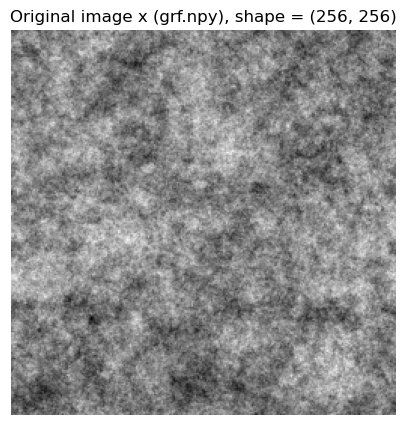

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Prefer ready-made, well-tested filters.
try:
    from scipy.ndimage import gaussian_filter, uniform_filter, convolve
    from scipy.signal import fftconvolve
except Exception as e:
    raise ImportError(
       
    )

# Load a demo image.
# - cat.npy: more structured
# - grf.npy: Gaussian random field (texture)
img_path = 'grf.npy'  # change to 'grf.npy' if you want

x = np.load(img_path).astype(float)
if x.ndim == 3:
    x = x.mean(axis=-1)

# Normalize for display
x = (x - x.min()) / (x.max() - x.min() + 1e-12)

# Guard: don't overwrite the image array with plotting objects
if not isinstance(x, np.ndarray):
    raise TypeError("x must be a numpy array. Don't do `x = plt.imshow(...)`; use `im = plt.imshow(...)` instead.")
H, W = x.shape

plt.figure(figsize=(5, 5))
plt.title(f"Original image x ({img_path}), shape = {x.shape}")
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.show()


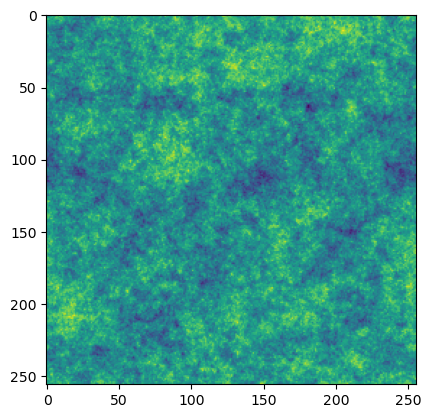

In [2]:
plt.imshow(np.fft.fftshift(x))

## 1) Discrete convolution (what it means)

An image is a discrete field

$$
x \in \mathbb{R}^{H\times W}, \qquad x[i,j] \ \text{for } 0\le i < H,\ 0\le j < W.
$$

A (2D) convolution with a kernel (filter)

$$
\psi \in \mathbb{R}^{(2r+1)\times(2r+1)}
$$

produces a new image

$$
(y = x * \psi)[i,j]
= \sum_{u=-r}^{r}\sum_{v=-r}^{r} \tilde{x}[i-u,\,j-v]\,\psi[u,v].
$$

Near the boundary, some indices \((i-u, j-v)\) fall outside the image. That is why we introduce a padded/extended image \(\tilde{x}\).


## 2) Padding (boundary handling)

When we say “same-size convolution”, we must decide what happens **outside** the image.

Common choices:

- **zero/constant padding**: pretend the image is surrounded by zeros (or a constant).
- **reflect padding**: mirror the image at the boundary.
- **nearest/replicate**: repeat the boundary pixel outward.
- **wrap/circular**: periodic boundary conditions.

In this notebook we will mostly use **reflect**, because it tends to avoid artificial dark borders when smoothing.


## Visualizing kernels (pixel space vs Fourier space)

Before filtering any image, it helps to look at the kernels themselves.

- In **pixel space**, a kernel shows the local weights.
- In **Fourier space**, the magnitude \(|\widehat{\psi}(k_1,k_2)|\) shows which frequencies are passed or suppressed.

Below we visualize a box kernel and a Gaussian kernel in both domains.

A note about the Gaussian: if you **crop** it very tightly in pixel space, you multiply it by a box window. That windowing can make the Fourier magnitude look less Gaussian (more 'boxy'). Below we compute the Fourier response from a large impulse response to avoid that artifact.


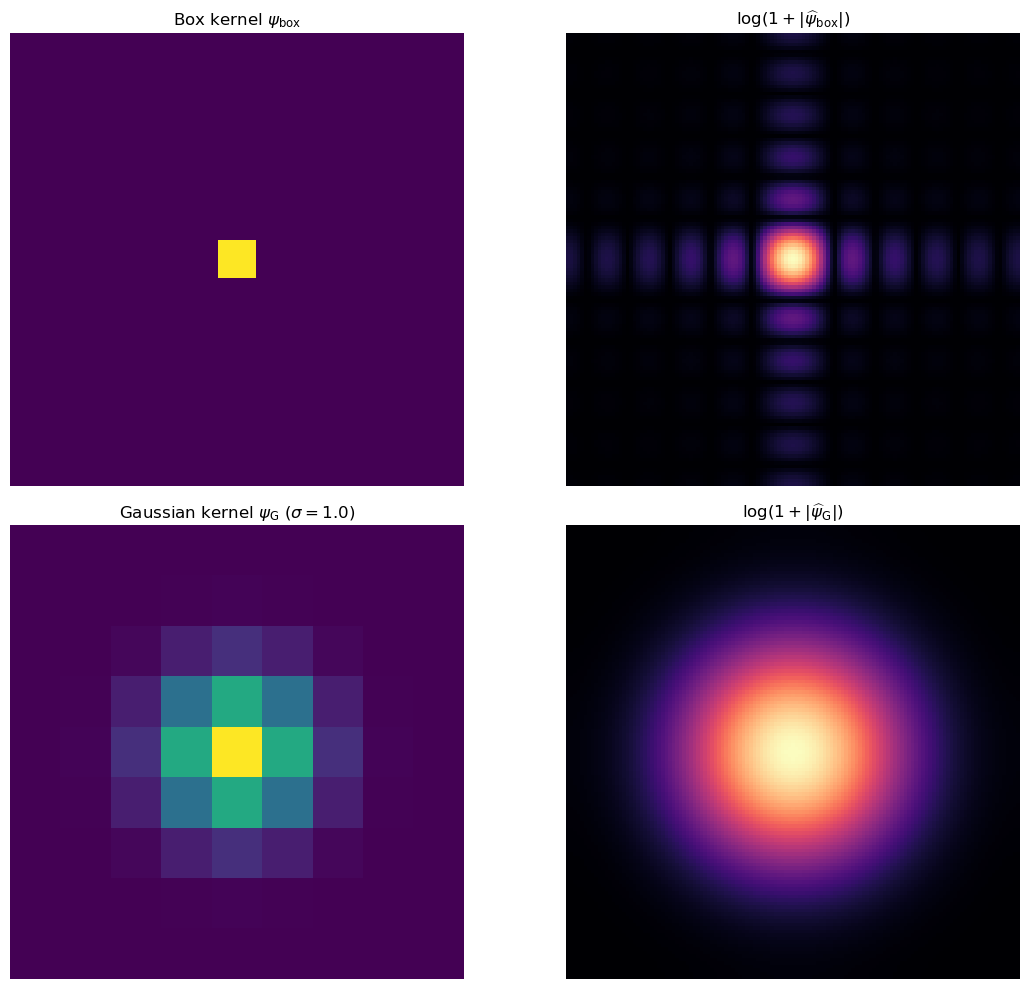

In [3]:
# 2x2: kernels in pixel space + Fourier magnitude
#
# Important: a Gaussian is only exactly Gaussian in Fourier space if it has *infinite support*.
# If you crop it tightly in pixel space, you multiply by a box window, which makes the Fourier
# response look more "boxy" (sinc/Dirichlet effects). To avoid that artifact, we compute the
# Fourier response from a *large* impulse response array, while still displaying a small
# central crop of the kernel in pixel space.

# Box kernel parameters
r_box = 5
size_box = 2 * r_box + 1

# Gaussian kernel parameters
sigma = 1.0
r_g = int(np.ceil(4 * sigma))  # display crop radius

# Build a sufficiently large canvas so the impulse response decays before the boundary
L = int(max(129, 8 * r_g + 1, 8 * r_box + 1))
if L % 2 == 0:
    L += 1

impulse = np.zeros((L, L), dtype=float)
impulse[L // 2, L // 2] = 1.0

# Impulse responses (ready-made SciPy filters)
psi_box_full = uniform_filter(impulse, size=size_box, mode='constant', cval=0.0)
psi_g_full = gaussian_filter(impulse, sigma=sigma, mode='constant', cval=0.0)

# Crops for pixel-space display
c = L // 2
psi_box = psi_box_full[c - r_box : c + r_box + 1, c - r_box : c + r_box + 1]
psi_g = psi_g_full[c - r_g : c + r_g + 1, c - r_g : c + r_g + 1]

# Fourier magnitudes computed from the *full* impulse responses
H_box = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psi_box_full)))
H_g = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psi_g_full)))

mag_box = np.log1p(np.abs(H_box))
mag_g = np.log1p(np.abs(H_g))

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title(r"Box kernel $\psi_{\mathrm{box}}$")
plt.imshow(psi_box_full, cmap='viridis')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title(r"$\log(1 + |\widehat{\psi}_{\mathrm{box}}|)$")
plt.imshow(mag_box, cmap='magma')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title(r"Gaussian kernel $\psi_{\mathrm{G}}$ ($\sigma=%.1f$)" % sigma)
plt.imshow(psi_g, cmap='viridis')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title(r"$\log(1 + |\widehat{\psi}_{\mathrm{G}}|)$")
plt.imshow(mag_g, cmap='magma')
plt.axis('off')

plt.tight_layout()
plt.show()


## 3) Smoothing with a box (averaging) filter

A box filter replaces each pixel by the average of its neighbors in a \((2r+1)\times(2r+1)\) window.

Using SciPy, this is just `uniform_filter`.


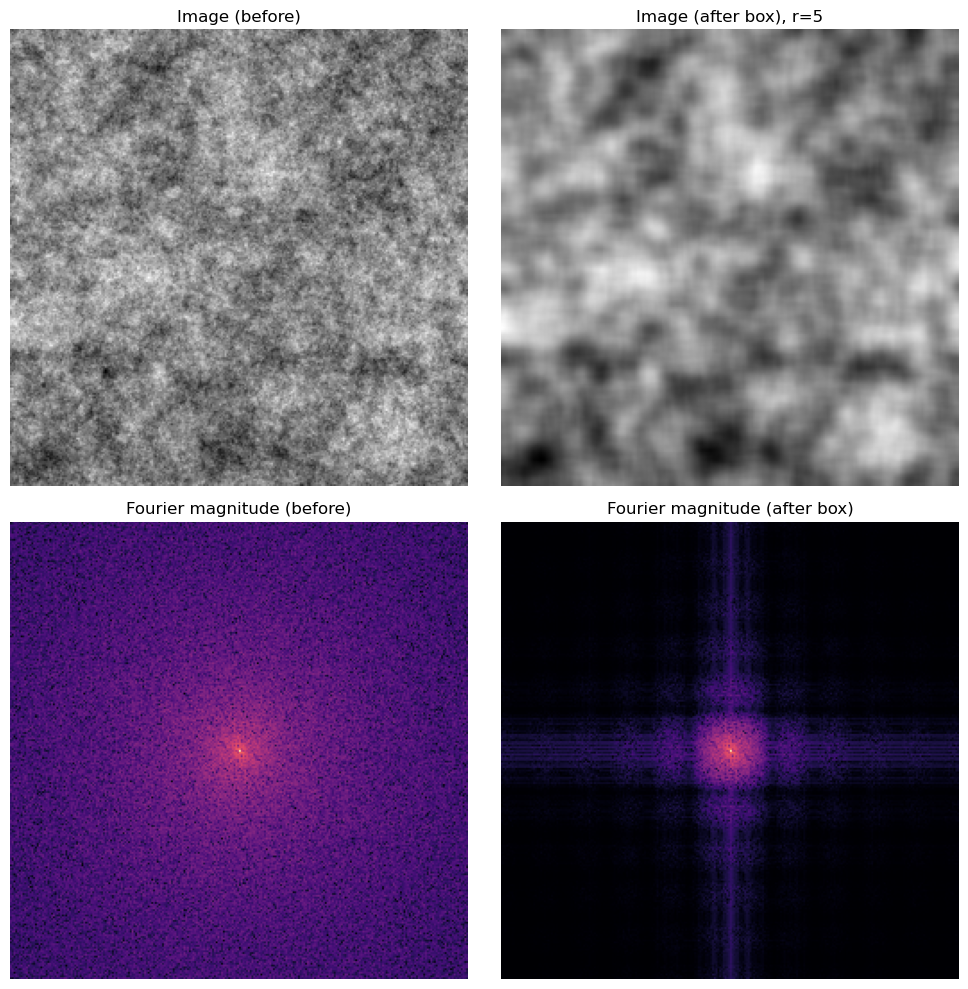

In [4]:
# Box (mean) filter
r = 5
size = 2 * r + 1

# reflect padding is a good default for smoothing
y_box = uniform_filter(x, size=size, mode='reflect')

# Fourier magnitudes (centered)
F_before = np.fft.fftshift(np.fft.fft2(x))
F_after  = np.fft.fftshift(np.fft.fft2(y_box))

mag_before = np.log1p(np.abs(F_before))
mag_after  = np.log1p(np.abs(F_after))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(x, cmap='gray')
plt.title('Image (before)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(y_box, cmap='gray')
plt.title(f'Image (after box), r={r}')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(mag_before, cmap='magma')
plt.title('Fourier magnitude (before)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(mag_after, cmap='magma')
plt.title('Fourier magnitude (after box)')
plt.axis('off')

plt.tight_layout()
plt.show()


### What you should see

- In pixel space: the image becomes **blurrier** (fine texture is smoothed away).
- In Fourier space: high frequencies (far from the center) are **attenuated**.

A box kernel has **sharp edges** in pixel space, and that corresponds to **ripples (sidelobes)** in Fourier space. This is why box filtering can produce “ringing-like” frequency structure.


## 4) Smoothing with a Gaussian filter

A Gaussian kernel is smoother than a box kernel, so its Fourier response is also smoother.

Using SciPy, this is `gaussian_filter`.


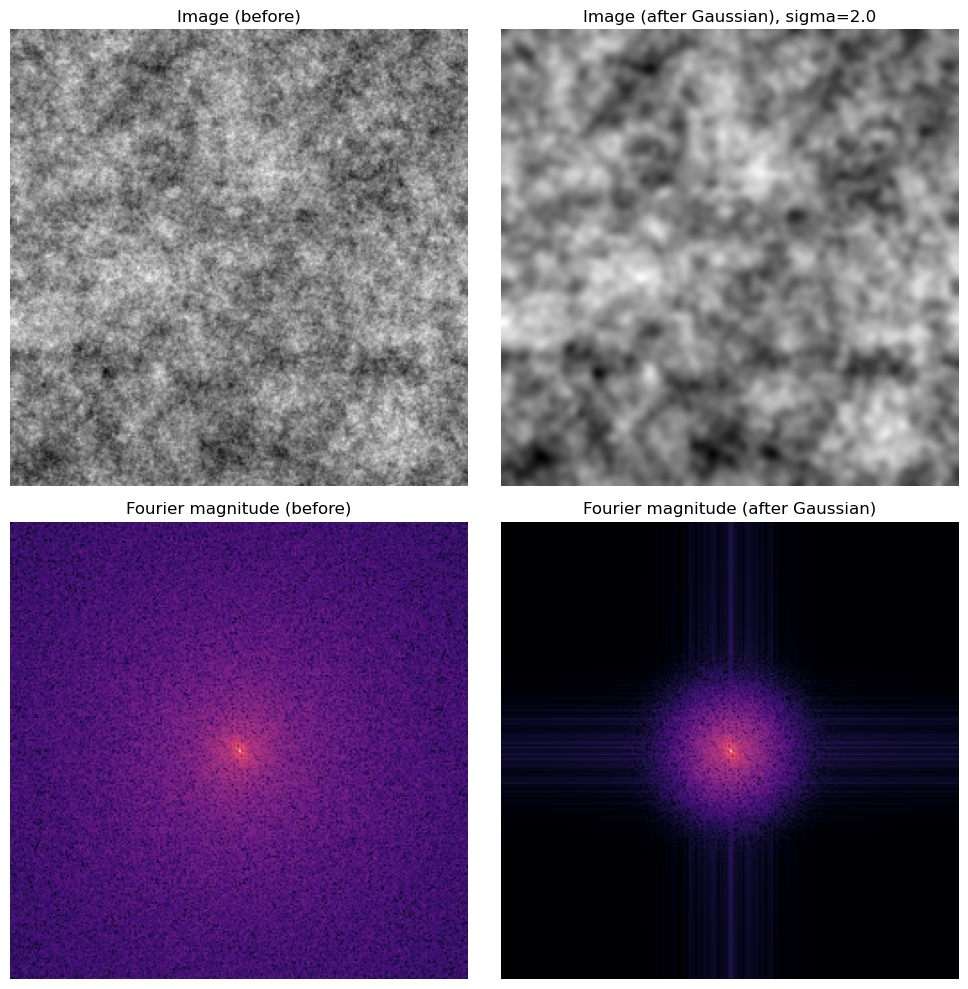

In [5]:
# Gaussian filter
sigma = 2.0

y_g = gaussian_filter(x, sigma=sigma, mode='reflect')

F_before = np.fft.fftshift(np.fft.fft2(x))
F_after  = np.fft.fftshift(np.fft.fft2(y_g))

mag_before = np.log1p(np.abs(F_before))
mag_after  = np.log1p(np.abs(F_after))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(x, cmap='gray')
plt.title('Image (before)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(y_g, cmap='gray')
plt.title(f'Image (after Gaussian), sigma={sigma}')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(mag_before, cmap='magma')
plt.title('Fourier magnitude (before)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(mag_after, cmap='magma')
plt.title('Fourier magnitude (after Gaussian)')
plt.axis('off')

plt.tight_layout()
plt.show()


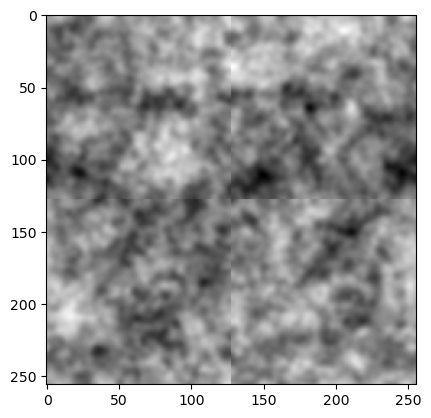

In [6]:
plt.imshow(np.fft.fftshift(y_g), cmap='gray')

### Box vs Gaussian (conceptual)

Both are **low-pass filters** (they suppress high frequencies), but they differ in an important way:

- Box kernel: sharp cutoff in space \(\Rightarrow\) **sinc/Dirichlet-like** Fourier response with sidelobes.
- Gaussian kernel: smooth in space \(\Rightarrow\) **Gaussian** Fourier response (no oscillatory sidelobes).

This is why Gaussian smoothing usually looks more “natural” and introduces fewer artifacts.


## 5) Convolution theorem (continuous proof)

Let \(f,g \in L^1(\mathbb{R}^d)\). Define their convolution

$$
(f*g)(x) = \int_{\mathbb{R}^d} f(y)\,g(x-y)\,dy.
$$

Define the Fourier transform (one common convention)

$$
\hat{f}(\xi) = \int_{\mathbb{R}^d} f(x)\,e^{-i x\cdot \xi}\,dx.
$$

**Theorem (Convolution theorem).**

$$
\widehat{f*g}(\xi) = \hat{f}(\xi)\,\hat{g}(\xi).
$$

**Proof.**

\begin{align*}
\widehat{f*g}(\xi)
&= \int_{\mathbb{R}^d} (f*g)(x)\,e^{-i x\cdot\xi}\,dx \\
&= \int_{\mathbb{R}^d}\left(\int_{\mathbb{R}^d} f(y)\,g(x-y)\,dy\right)e^{-i x\cdot\xi}\,dx \\
&= \int_{\mathbb{R}^d} f(y)\left(\int_{\mathbb{R}^d} g(x-y)\,e^{-i x\cdot\xi}\,dx\right)dy.
\end{align*}

In the inner integral, change variables \(z=x-y\):

\begin{align*}
\int_{\mathbb{R}^d} g(x-y)\,e^{-i x\cdot\xi}\,dx
&= \int_{\mathbb{R}^d} g(z)\,e^{-i (z+y)\cdot\xi}\,dz \\
&= e^{-i y\cdot\xi}\int_{\mathbb{R}^d} g(z)\,e^{-i z\cdot\xi}\,dz.
\end{align*}

Substitute back:

\begin{align*}
\widehat{f*g}(\xi)
&= \left(\int_{\mathbb{R}^d} f(y)\,e^{-i y\cdot\xi}\,dy\right)
   \left(\int_{\mathbb{R}^d} g(z)\,e^{-i z\cdot\xi}\,dz\right) \\
&= \hat{f}(\xi)\,\hat{g}(\xi).
\end{align*}

\(\square\)

For discrete images, the same idea holds with the discrete Fourier transform (DFT): **convolution in space corresponds to multiplication in frequency** (with details depending on padding vs periodic assumptions).


## 6) (Optional) Numerical check of the convolution theorem (zero padding)

To avoid boundary-condition confusion, we will use **zero padding** here.

We will compare:

- spatial convolution: `scipy.ndimage.convolve(..., mode='constant', cval=0.0)`
- FFT convolution: `scipy.signal.fftconvolve(..., mode='same')`

These should match up to floating point error.


max |spatial - fft| = 1.2212453270876722e-15


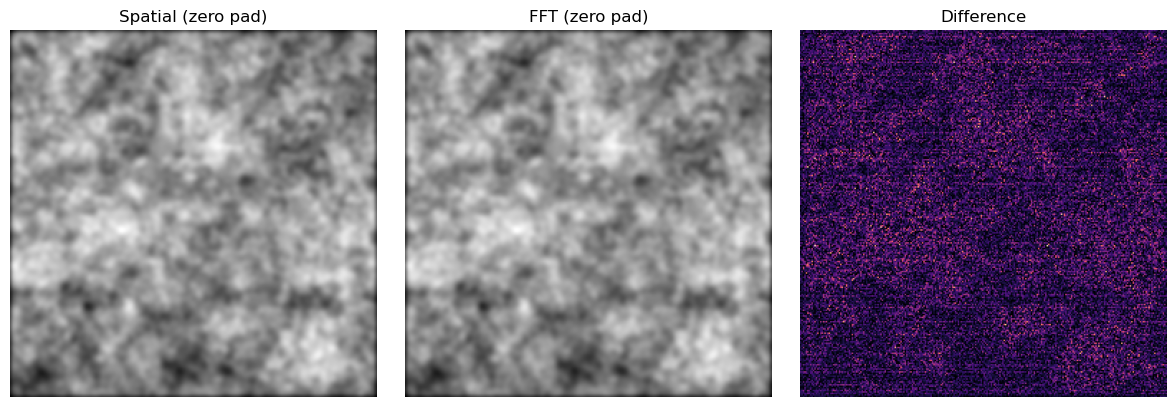

In [7]:
def box_kernel(radius: int) -> np.ndarray:
    k = 2 * radius + 1
    psi = np.ones((k, k), dtype=float)
    return psi / psi.sum()


def gaussian_kernel(radius: int, sigma: float) -> np.ndarray:
    u = np.arange(-radius, radius + 1)
    v = np.arange(-radius, radius + 1)
    U, V = np.meshgrid(u, v, indexing='ij')
    psi = np.exp(-(U**2 + V**2) / (2 * sigma**2))
    return psi / psi.sum()

# Pick a kernel (symmetric kernels avoid convolution-vs-correlation sign conventions)
r = 6
sigma = 2.0
psi = gaussian_kernel(radius=r, sigma=sigma)

# Zero-padded spatial convolution
y_spatial = convolve(x, psi, mode='constant', cval=0.0)

# FFT-based linear convolution (effectively zero padding)
y_fft = fftconvolve(x, psi, mode='same')

err = np.max(np.abs(y_spatial - y_fft))
print('max |spatial - fft| =', err)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Spatial (zero pad)')
plt.imshow(y_spatial, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('FFT (zero pad)')
plt.imshow(y_fft, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
plt.imshow(np.abs(y_spatial - y_fft), cmap='magma')
plt.axis('off')

plt.tight_layout()
plt.show()


## 7) Why does the box filter look “boxy” in Fourier space?

If \($\psi_{\mathrm{box}}$\) is a square averaging kernel, it is separable:

$$
\psi_{\mathrm{box}}(u,v) = b(u)\,b(v),
$$

so its Fourier transform factors:

$$
\widehat{\psi}_{\mathrm{box}}(k_1,k_2) = \widehat{b}(k_1)\,\widehat{b}(k_2).
$$

Compute the Fourier transform of a box function. 

You have already computed the fourier transform of a Gaussian. It is more well behaved.
A Gaussian does not have sharp edges, so its Fourier response is smooth and radially symmetric.


## Shifted Gaussian in Fourier space (not centered at $\mathbf{k}=0$)

So far, our smoothing filters were **low-pass**: their Fourier response is centered at the origin.

We can also build a *band-pass* filter by placing a Gaussian **away from** $k=0$ in Fourier space:

$$
\widehat{\psi}(k_x,k_y)
= \exp\!\left(-\frac{(k_x-k_{x0})^2 + (k_y-k_{y0})^2}{2\,\sigma_k^2}\right).
$$

Multiplying $\widehat{x}$ by this mask keeps only frequencies near $(k_{x0},k_{y0})$.

**Note.** A single off-center bump is generally *not* conjugate-symmetric, so the inverse FFT can be complex. To keep a real-valued filtered image, we (optionally) add the symmetric bump at $(-k_{x0},-k_{y0})$.


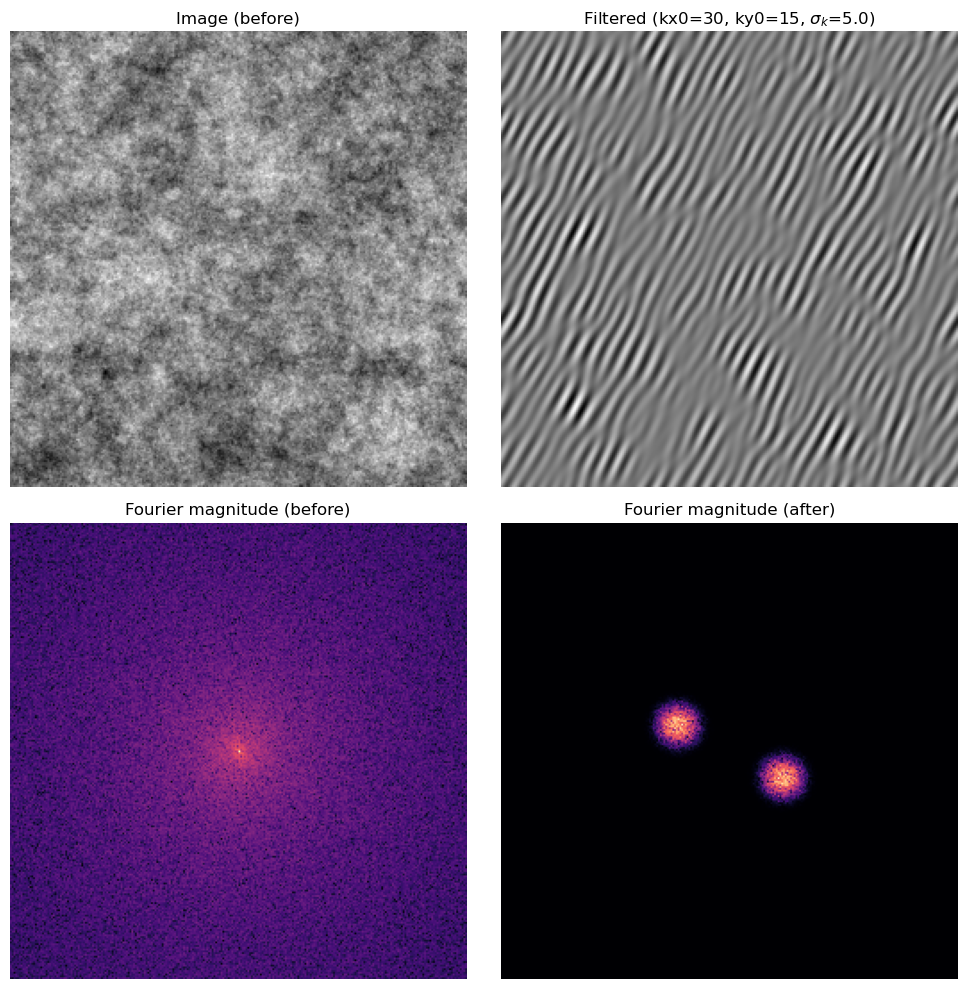

In [8]:
# Shifted Gaussian mask in Fourier space

# User parameters (in *FFT-shifted index units*)
kx0 = 30
ky0 = 15
sigma_k = 5.0
use_conjugate_pair = True  # set False to see a complex-valued output

# FFT of the image (shifted so k=0 is at the center)
F = np.fft.fftshift(np.fft.fft2(x))

# Frequency grid as integer indices (same layout as fftshift)
ky = np.arange(-H // 2, H // 2)
kx = np.arange(-W // 2, W // 2)
KX, KY = np.meshgrid(kx, ky)

# Gaussian bump(s) in Fourier space
G1 = np.exp(-((KX - kx0) ** 2 + (KY - ky0) ** 2) / (2 * sigma_k ** 2))
if use_conjugate_pair:
    G2 = np.exp(-((KX + kx0) ** 2 + (KY + ky0) ** 2) / (2 * sigma_k ** 2))
    G = G1 + G2
else:
    G = G1

# Apply the mask
F_filt = F * G

# Back to pixel space
y_shift = np.fft.ifft2(np.fft.ifftshift(F_filt))

y_show = y_shift.real if use_conjugate_pair else np.abs(y_shift)

mag_before = np.log1p(np.abs(F))
mag_after = np.log1p(np.abs(F_filt))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(x, cmap='gray')
plt.title('Image (before)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(y_show, cmap='gray')
plt.title(rf'Filtered (kx0={kx0}, ky0={ky0}, $\sigma_k$={sigma_k})')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(mag_before, cmap='magma')
plt.title('Fourier magnitude (before)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(mag_after, cmap='magma')
plt.title('Fourier magnitude (after)')
plt.axis('off')

plt.tight_layout()
plt.show()


## Morlet wavelet (band-pass, zero-mean)

The previous “shifted Gaussian in Fourier space” is a good **band-pass mask**, but a *Morlet wavelet* adds one extra idea: it is designed to have **zero mean** in pixel space.

Zero mean is useful because it makes the wavelet respond to **changes/oscillations** rather than the overall brightness (the DC component).

A common 2D Morlet wavelet can be described in Fourier space as a Gaussian bump centered at $(k_{x0},k_{y0})$, **with a correction term** that forces the response at $k=0$ to be zero:

$$
\widehat{\psi}_{\mathrm{Mor}}(k_x,k_y)
= \exp\!\left(-\frac{(k_x-k_{x0})^2 + (k_y-k_{y0})^2}{2\sigma_k^2}\right)
\; - \;
\exp\!\left(-\frac{k_x^2+k_y^2}{2\sigma_k^2}\right)
\exp\!\left(-\frac{k_{x0}^2+k_{y0}^2}{2\sigma_k^2}\right).
$$

This guarantees $\widehat{\psi}_{\mathrm{Mor}}(0,0)=0$, i.e. no DC.

As before, to keep the filtered image real-valued, we can optionally add the symmetric bump at $(-k_{x0},-k_{y0})$.


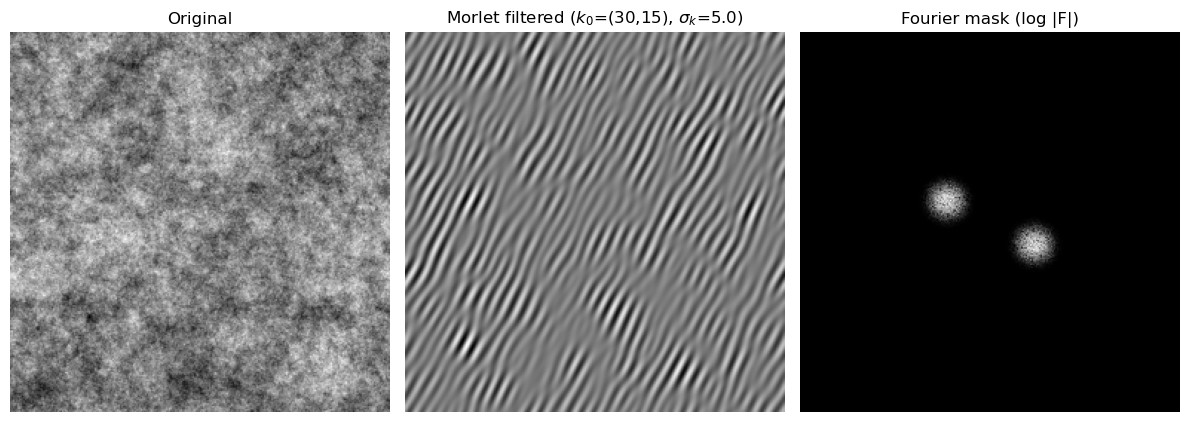

In [9]:
# Morlet wavelet mask in Fourier space (zero-mean correction)

# Use the same image array as the rest of this notebook
I = x
if not isinstance(I, np.ndarray):
    raise TypeError(
        "x must be a numpy array. Did you accidentally do `x = plt.imshow(...)`? "
        "Use `im = plt.imshow(...)` instead."
    )

H, W = I.shape

# FFT
F = np.fft.fft2(I)
Fshift = np.fft.fftshift(F)

# Fourier coordinates (fftshift indexing)
kx = np.arange(-W // 2, W // 2)
ky = np.arange(-H // 2, H // 2)
KX, KY = np.meshgrid(kx, ky)

# User parameters
kx0, ky0 = 30, 15        # center in Fourier space
sigma_k = 5.0            # width of the bump
use_conjugate_pair = True

# Base isotropic Gaussian in Fourier
G0 = np.exp(-(KX**2 + KY**2) / (2 * sigma_k**2))
Gk0 = np.exp(-(kx0**2 + ky0**2) / (2 * sigma_k**2))

# One Morlet bump (zero mean in space <=> mask(0)=0 in Fourier)
G1 = np.exp(-((KX - kx0)**2 + (KY - ky0)**2) / (2 * sigma_k**2))
Mor1 = G1 - G0 * Gk0

if use_conjugate_pair:
    G2 = np.exp(-((KX + kx0)**2 + (KY + ky0)**2) / (2 * sigma_k**2))
    Mor2 = G2 - G0 * Gk0
    Morlet = Mor1 + Mor2
else:
    Morlet = Mor1

# Apply as band-pass filter
F_mor = Fshift * Morlet

# Inverse FFT
I_mor = np.fft.ifft2(np.fft.ifftshift(F_mor))
I_show = I_mor.real if use_conjugate_pair else np.abs(I_mor)

# Spectrum for display
P_mor = np.log1p(np.abs(F_mor))

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(I, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title(rf"Morlet filtered ($k_0$=({kx0},{ky0}), $\sigma_k$={sigma_k})")
plt.imshow(I_show, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Fourier mask (log |F|)")
plt.imshow(P_mor, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()
